# Aufbau der Notebooks [Philipp]

- Multivalue bei Notebooks angucken
- Wie installiere ich den "scheiß"
- Widgets: https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html


In [2]:
# Importing libraries
from enum import Enum
import ipywidgets as widgets
from pandas import read_csv
import os
import numpy as np
import time

In [3]:
# Setting up the global variables

PATH_RAW_DATA = "./data/raw/"
PATH_FEATURE_DATA = "./data/"
PATH_EXPLORATION_DATA = "./exploration/"
PATH_MODEL = "./models/"
DATA_SOURCE_KIDAQ = ["TEST_NAME", "TEST_TYPE", "RPM", "FLOW_RATE", "P1", "P2"]
RAW_DATA_TYPE = ["KIDAQ", "VIB"]

DATA_SOURCE_VID = [
    "TEST_NAME",
    "TEST_TYPE",
    "RPM",
    "FLOW_RATE",
    "S1",
    "S2",
    "S3",
    "S4",
    "S5",
    "S6",
    "S7",
    "S8",
]
FEATURE = [
    "STD",
    "RANGE",
    "IQR",
    "MEAN_MEDIAN",
    "FFT",
]
OPERATING_POINT_FREQ = [725, 1450, 2175, 2900]
OPERATING_POINT_FLOW_RATE = [0, 25, 50, 75, 100]

DEFAULT_RAW_DATA_TYPE = RAW_DATA_TYPE[1]
DEFAULT_RAW_DATA = DATA_SOURCE_KIDAQ

DEFAULT_CLASS_LABEL = "TEST_TYPE"

## 1. Aufgabe und Daten erklären/beschreiben [Philipp]


## 3. Preprocessing [Valerij]

Aufgeteilt nach KIDAQ und VIB (separat um es einfach zu halten)

- Auswahl der Fenstergröße in Millisekunden
- Auswahl der Abtastrate
- Multi-Selektion der Aggregation (avg, mean, std, ...)
- Frequenzanalyse
- Fourier-Transformation
- Fenstergröße nach Frequenzbereichen

### 3.1 Vorbereitung der Tainings- und Testdaten

Multi-Selektion für:

- Features
- Betriebspunkte (RPM/FLOWRATE)
- Klassifikationsarten (Szenario / Testdurchlauf)


## 4. Deskriptive/Explorative Datenanalyse [Philipp]

- Plots
- Beschreibung der Plots


## 5. Maschinelles Lernen [Kevin]

In diesem Bereich können, mithilfe drei verschiedener Learner, Modell anhand der generierten Trainings- und Testdaten erzeugt werden.

### 5.1 Trainings- und Testdaten wählen und laden

In [ ]:
# SELECT TRAINING AND TEST DATA
featureDataDir = list(filter(lambda x: os.path.isfile(os.path.join(PATH_FEATURE_DATA, x)) and DEFAULT_RAW_DATA_TYPE in x.upper(), os.listdir(PATH_FEATURE_DATA)))

trainFileDropdown = widgets.Dropdown(description="training data")
trainFileDropdown.options = featureDataDir
selectedTrainFile = None
def onTrainigFileChange(change):
    global selectedTrainFile
    selectedTrainFile = change['new']
trainFileDropdown.observe(onTrainigFileChange, names='value')
display(trainFileDropdown)

testFileDropdown = widgets.Dropdown(description="test data")
testFileDropdown.options = featureDataDir
selectedTestFile = None
def onTestFileChange(change):
    global selectedTestFile
    selectedTestFile = change['new']
testFileDropdown.observe(onTestFileChange, names='value')
display(testFileDropdown)


In [ ]:
# LOAD DATA

csvTrain = read_csv(PATH_FEATURE_DATA + selectedTrainFile, delimiter=";")
csvTest = read_csv(PATH_FEATURE_DATA + selectedTestFile, delimiter=";")



trainData = csvTrain.values
testData = csvTest.values


featureNames = csvTrain.columns.values[2:].tolist()
trainX, trainY = trainData[:, 2:].astype('float32'), trainData[:, 1:2]
testX, testY = testData[:, 2:].astype('float32'), testData[:, 1:2]

### 5.2 Entscheidungsbaum - sklearn (empfohlen)


In diesem Abschnitt wird mit der sklearn-Bibliothek ein Entscheidungsbaummodell trainiert. Dabei können verschiedene Parameter frei gewählt werden, wie die maximale Baumtiefe, die gewünschte Mindestgenauigkeit und die Anzahl der Suchiterationen.
Das Programm wird dann versuchen, ausgehend von einer Baumtiefe von eins, einen möglichst einfachen Entscheidungsbaum zu generieren, der die gewünschte Genauigkeit erreicht.

#### 5.2.1 Konfiguration

In [ ]:
DT_MAX_DEPTH = 10                           # Maximum depth of the tree
DT_EXPLORATION_TARGET_VAL_ACCURACY = 0.95   # Target accuracy for the decision tree
DT_EXPLORATION_MAX_ITER = 100000            # Maximum number of iterations for the random search

#### 5.2.2 Trainieren

In [ ]:
# Train DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import joblib

labelEncoder = LabelEncoder()
labelEncoder = labelEncoder.fit(np.ravel(trainY))
labelEncodedTrainY = labelEncoder.transform(np.ravel(trainY))
labelEncodedTestY = labelEncoder.transform(np.ravel(testY))


testAccuracy = 0.0
trainAccuracy = 0.0
iterations = 0
depth = 1
while (
    testAccuracy < DT_EXPLORATION_TARGET_VAL_ACCURACY
    or trainAccuracy < DT_EXPLORATION_TARGET_VAL_ACCURACY
) and iterations < DT_EXPLORATION_MAX_ITER:
    # Create decision tree classifier
    

    dt = DecisionTreeClassifier(max_depth=depth, splitter="random")
    dt.fit(trainX, labelEncodedTrainY)

    testPredictions = dt.predict(testX)
    testAccuracy = accuracy_score(labelEncodedTestY, testPredictions)

    trainPredictions = dt.predict(trainX)
    trainAccuracy = accuracy_score(labelEncodedTrainY, trainPredictions)
    iterations += 1
    
    print("Iteration: %d" % iterations)
    print("Depth: %d" % depth)
    print("Train Accuracy: %.2f%%" % (trainAccuracy * 100.0))
    print("Test Accuracy: %.2f%%" % (testAccuracy * 100.0))

    depth = 1 + iterations // (DT_EXPLORATION_MAX_ITER // DT_MAX_DEPTH)




modelName = "dtc." + str(round(time.time()))
os.makedirs(PATH_MODEL + modelName)
with open(PATH_MODEL + modelName + "/encoder.pickle", "wb") as f:
    joblib.dump(labelEncoder, f)
joblib.dump(dt, PATH_MODEL + modelName + "/dtc.model")

### 5.3 Tiefes neuronales Netz - tensorflow

Im folgenden Abschnitt wird mit der tensorflow-Bibliothek ein tiefes neuronales Netzwerk trainiert. Dabei können verschiedene Parameter eingestellt werden, wie die gewünschte Mindestgenauigkeit, die Anzahl der Suchiterationen, die minimale und maximale Anzahl an Schichten und Neuronen, die Toleranz für einen vorzeitigen Abbruch einer Iteration, die Ausgabeform, die maximale Anzahl an Epochen, die Batchgröße und die Batch Normalisierung.

Bitte beachte, dass die genaue Syntax und die verfügbaren Optionen von tensorflow abhängen können. Es ist empfehlenswert, die offizielle tensorflow-Dokumentation für detaillierte Informationen zu konsultieren.

#### 5.3.1 Konfiguration

In [ ]:
DNN_EXPLORATION_TARGET_VAL_ACCURACY = 0.98  # Target accuracy for the neural network
DNN_EXPLORATION_MAX_ITER = 100              # Maximum number of iterations for the random search
DNN_EXPLORATION_HIDDEN_LAYERS_MIN = 1       # Minimum number of hidden layers
DNN_EXPLORATION_HIDDEN_LAYERS_MAX = 3       # Maximum number of hidden layers
DNN_EXPLORATION_NEURONS_MIN = 4             # Minimum number of neurons per layer
DNN_EXPLORATION_NEURONS_MAX = 16            # Maximum number of neurons per layer


DNN_EARLY_STOPPING_PATIENCE = 50            # Patience for early stopping
DNN_VERBOSE = 1                             # Verbosity level for the neural network
DNN_EPOCHS = 2000                           # Maximum number of epochs for the neural network
DNN_BATCH_SIZE = 128                        # Batch size for the neural network
DNN_BATCH_NORMALIZATION = True              # Batch normalization for the neural network

#### 5.3.2 Trainieren

In [ ]:
# Train Neural Network
import json
import random
import joblib
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

onehotencoder = OneHotEncoder()
onehotencoder = onehotencoder.fit(trainY)
onehotEncodedTrainY = onehotencoder.transform(trainY).toarray()
onehotEncodedTestY = onehotencoder.transform(testY).toarray()

explorationResults = []


n_features = trainX.shape[1]
categorieCount = len(onehotEncodedTrainY[0])

testAccuracy = 0.0
trainAccuracy = 0.0
model = Sequential()
interation = 0
while (
    testAccuracy < DNN_EXPLORATION_TARGET_VAL_ACCURACY
    or trainAccuracy < DNN_EXPLORATION_TARGET_VAL_ACCURACY
) and interation < DNN_EXPLORATION_MAX_ITER:
    model = Sequential()
    model.add(InputLayer(input_shape=(n_features,)))
    if DNN_BATCH_NORMALIZATION:
        model.add(BatchNormalization())
    denseCount = random.randint(
        DNN_EXPLORATION_HIDDEN_LAYERS_MIN, DNN_EXPLORATION_HIDDEN_LAYERS_MAX
    )
    denseNeurons = []
    for i in range(0, denseCount):
        neuronCount = random.randint(
            DNN_EXPLORATION_NEURONS_MIN, DNN_EXPLORATION_NEURONS_MAX
        )
        denseNeurons.append(neuronCount)
        model.add(Dense(neuronCount, activation="tanh"))
        if DNN_BATCH_NORMALIZATION:
            model.add(BatchNormalization())
    model.add(Dense(categorieCount, activation="sigmoid"))
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.fit(
        trainX,
        onehotEncodedTrainY,
        epochs=DNN_EPOCHS,
        batch_size=DNN_BATCH_SIZE,
        verbose=DNN_VERBOSE,
        validation_data=(testX, onehotEncodedTestY),
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                patience=DNN_EARLY_STOPPING_PATIENCE,
                restore_best_weights=True,
            )
        ],
    )

    trainLoss, trainAccuracy = model.evaluate(trainX, onehotEncodedTrainY)
    testLoss, testAccuracy = model.evaluate(testX, onehotEncodedTestY)

    explorationResults.append(
        {
            "dense_count": denseCount,
            "dense_neurons": denseNeurons,
            "train_loss": trainLoss,
            "train_acc": trainAccuracy,
            "test_loss": testLoss,
            "test_acc": testAccuracy,
        }
    )
    interation += 1

modelName = "dnn." + str(round(time.time()))

model.save(PATH_MODEL + modelName)

with open(PATH_MODEL + modelName + "/encoder.pickle", "wb") as f:
    joblib.dump(onehotencoder, f)

with open(PATH_EXPLORATION_DATA + modelName + ".exploration_results.json", "w") as f:
    json.dump(explorationResults, f, indent=4)

### 5.4 Extremes Gradienten-Boosting - XGBoost

In diesem Abschnitt wird mit der xgboost-Bibliothek ein Modell mithilfe des "Extreme Gradient Boosting" trainiert. Dabei können verschiedene Parameter frei gewählt werden, wie die maximale Anzahl der Bäume, die gewünschte Mindestgenauigkeit und die Anzahl der Suchiterationen.

#### 5.4.1 Konfiguration

In [ ]:
DT_MAX_DEPTH = 10                           # Maximum depth of the tree
DT_EXPLORATION_TARGET_VAL_ACCURACY = 0.95   # Target accuracy for the decision tree
DT_EXPLORATION_MAX_ITER = 100000            # Maximum number of iterations for the random search

DT_NUM_OF_ESTIMATORS = None                 # number of estimators (default = None -> number of estimators = number of classes)

#### 5.4.2 Trainieren

In [ ]:
# Train XGBClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import joblib


labelEncoder = LabelEncoder()
labelEncoder = labelEncoder.fit(np.ravel(trainY))
labelEncodedTrainY = labelEncoder.transform(np.ravel(trainY))
labelEncodedTestY = labelEncoder.transform(np.ravel(testY))

testAccuracy = 0.0
trainAccuracy = 0.0
iterations = 0
while (
    testAccuracy < DT_EXPLORATION_TARGET_VAL_ACCURACY
    or trainAccuracy < DT_EXPLORATION_TARGET_VAL_ACCURACY
) and iterations < DT_EXPLORATION_MAX_ITER:
    xgb = XGBClassifier(
        tree_method="hist",
        enable_categorical=True,
        max_depth=DT_MAX_DEPTH,
        n_estimators=labelEncoder.classes_.size if DT_NUM_OF_ESTIMATORS == None else DT_NUM_OF_ESTIMATORS,
        random_state=np.random.randint(),
    )
    # fit model
    labeledTrainX = pd.DataFrame(trainX, columns=featureNames)
    labeledTestX = pd.DataFrame(testX, columns=featureNames)

    xgb.fit(
        labeledTrainX, labelEncodedTrainY, eval_set=[(labeledTestX, labelEncodedTestY)]
    )

    testPredictions = xgb.predict(testX)
    testAccuracy = accuracy_score(labelEncodedTestY, testPredictions)

    trainPredictions = xgb.predict(trainX)
    trainAccuracy = accuracy_score(labelEncodedTrainY, trainPredictions)
    iterations += 1

modelName = "xgb." + str(round(time.time()))
os.makedirs(PATH_MODEL + modelName)

with open(PATH_MODEL + modelName + "/encoder.pickle", "wb") as f:
    joblib.dump(labelEncoder, f)


XGBClassifier.save_model(xgb, PATH_MODEL + modelName + "/xgb.model")

featureMap = xgb.get_booster().get_score(importance_type="gain")

with open(PATH_MODEL + modelName + "/feature_map.txt", "w") as file:
    for index, feature in enumerate(xgb.get_booster().feature_names):
        file.write(f"{index}\t{feature}\tq\n")


print("Accuracy: %.2f%%" % (testAccuracy * 100.0))

## 6. Modelanalyse des Learners [Kevin]

**In diesem Abschnitt können in Abhängigkeit von der Auswahl des zu analysierenden Modells verschiedene Analysen durchgeführt werden.**

- *Visuelle Darstellung (nur Entscheidungsbaum/Extremes Gradienten-Boosting)*: Eine visuelle Darstellung des Modells kann erstellt werden, um die Entscheidungslogik und Struktur intuitiv zu erfassen.

- *Konfusionsmatrix*: Eine Konfusionsmatrix wird erstellt, um die Leistung des Modells bei der Klassifikation zu bewerten. Sie zeigt, wie gut das Modell verschiedene Klassen korrekt vorhersagt und welche Fehler gemacht werden.

- *Test-Genauigkeit*: Die Test-Genauigkeit wird berechnet, um zu bewerten, wie gut das Modell auf unbekannten Daten abschneidet. Dies gibt einen Indikator dafür, wie zuverlässig die Vorhersagen des Modells sind.

- *Feature Importances*: Es wird eine Analyse der Feature Importances durchgeführt, um die relative Bedeutung der verschiedenen Merkmale bei der Vorhersage zu bestimmen. Dies ermöglicht Einblicke in die relevanten Merkmale und kann bei der Feature-Auswahl oder -Gewichtung helfen.

Diese Analysen bieten einen umfassenden Einblick in die Leistung und Funktionsweise des ausgewählten Modells und unterstützen bei der Interpretation der Ergebnisse.

In [4]:
# SELECT LEARNER AND TEST DATA
featureDataDir = list(filter(lambda x: os.path.isfile(os.path.join(PATH_FEATURE_DATA, x)) and DEFAULT_RAW_DATA_TYPE in x.upper(), os.listdir(PATH_FEATURE_DATA)))
modelDir = os.listdir(PATH_MODEL)

modelDropdown = widgets.Dropdown(description="model")
modelDropdown.options = modelDir
selectedModelFile = None
def onTrainigFileChange(change):
    global selectedModelFile
    selectedModelFile = change['new']
modelDropdown.observe(onTrainigFileChange, names='value')
display(modelDropdown)

testFileDropdown = widgets.Dropdown(description="test data")
testFileDropdown.options = featureDataDir
selectedTestFile = None
def onTestFileChange(change):
    global selectedTestFile
    selectedTestFile = change['new']
testFileDropdown.observe(onTestFileChange, names='value')
display(testFileDropdown)


Dropdown(description='model', options=('dnn.1685488608', 'dtc.1685576408', 'dtc.1685650137', 'dtc.1685658173',…

Dropdown(description='test data', options=('vib.test.setup2.csv', 'vib.train.setup1.csv'), value=None)

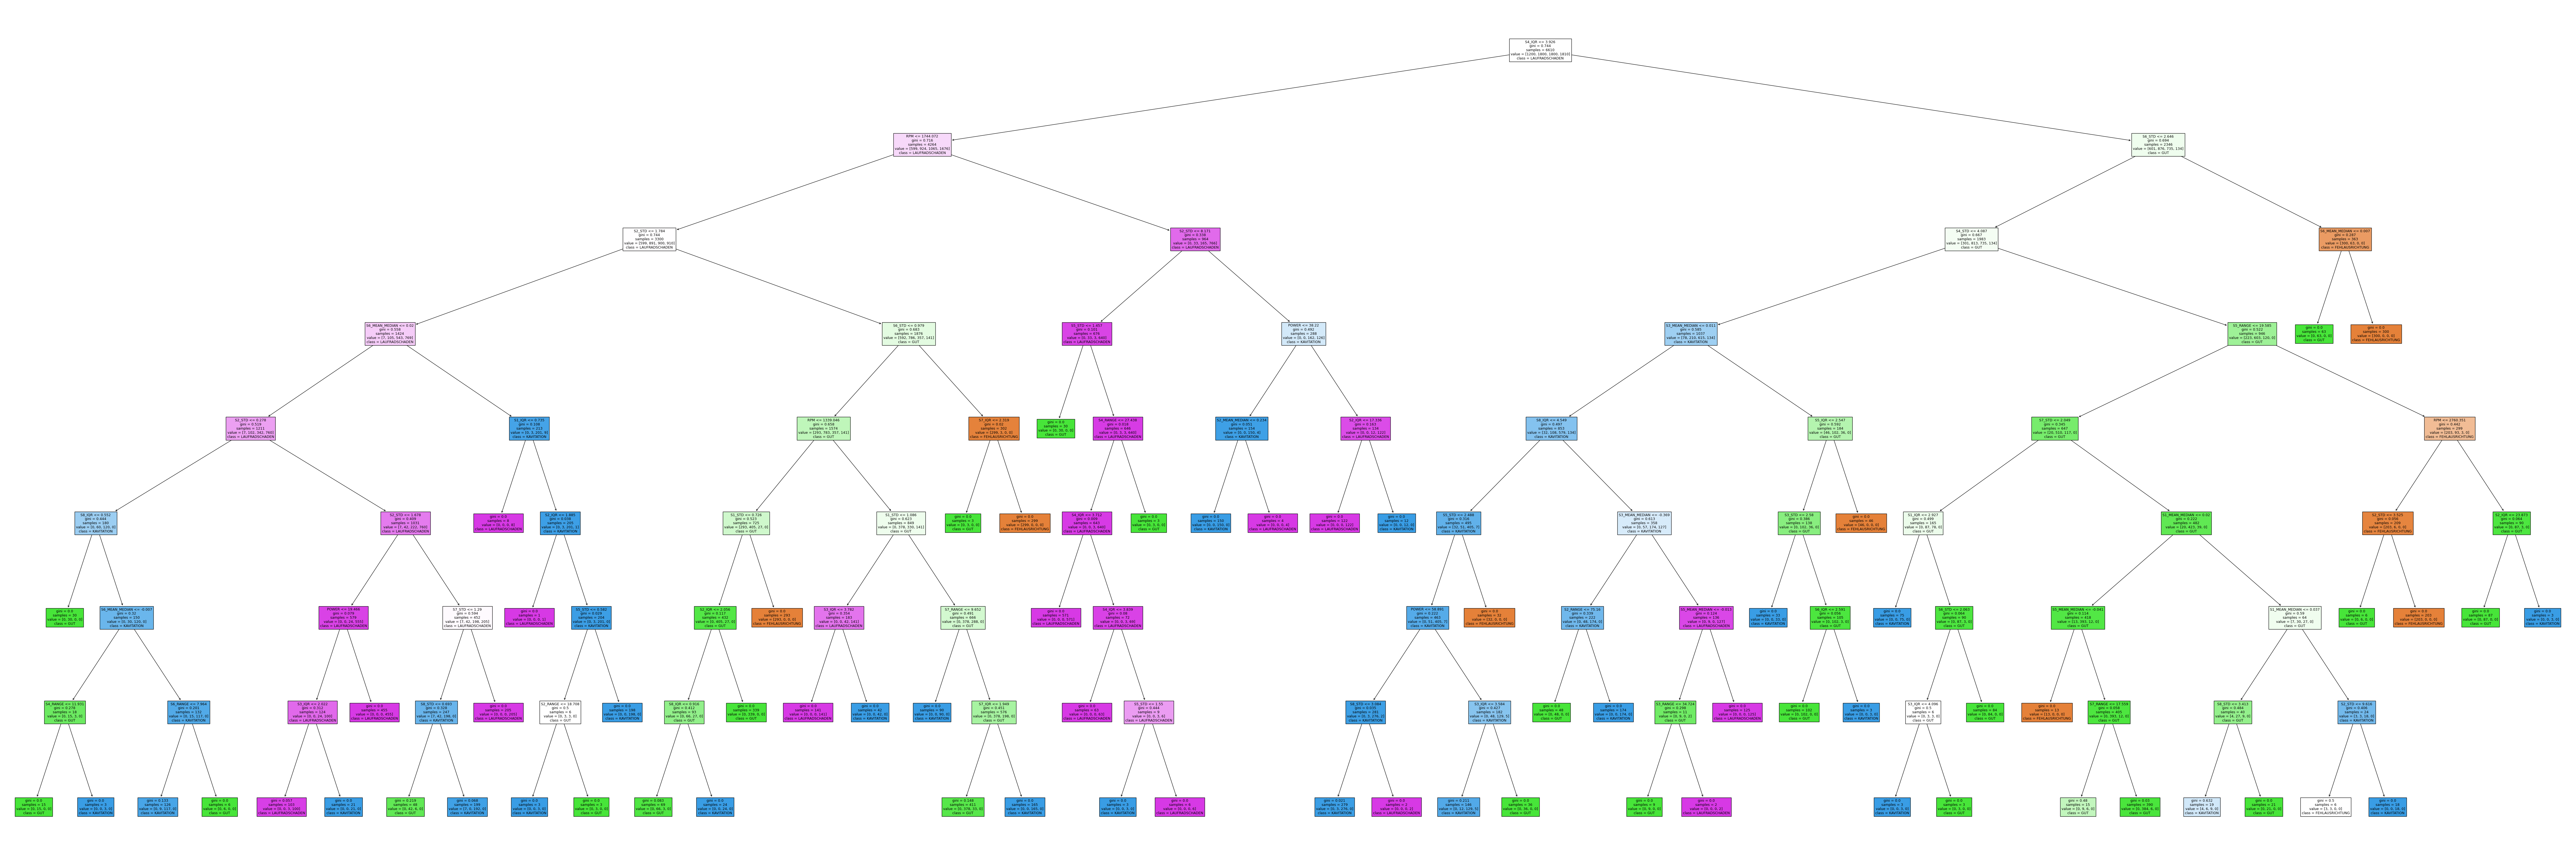

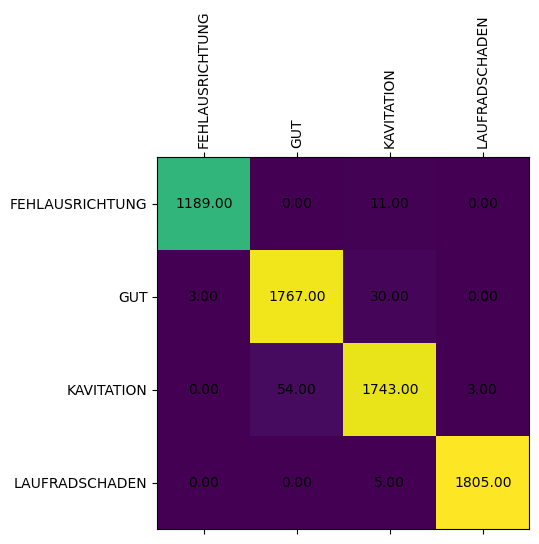

Test Accuracy: 0.984
Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

1.3078 ± 0.0375  RPM
0.6042 ± 0.0308  S4_IQR
0.3860 ± 0.0268  S6_STD
0.3356 ± 0.0246  S2_STD
0.2278 ± 0.0253  S5_STD
0.1939 ± 0.0069  S8_IQR
0.1205 ± 0.0070  S1_STD
0.1072 ± 0.0163  S3_MEAN_MEDIAN
0.1007 ± 0.0037  S4_STD
0.0951 ± 0.0108  S4_RANGE
0.0742 ± 0.0068  S6_MEAN_MEDIAN
0.0737 ± 0.0066  S7_STD
0.0638 ± 0.0049  S7_IQR
0.0407 ± 0.0023  S3_IQR
0.0375 ± 0.0023  POWER
0.0286 ± 0.0032  S5_IQR
0.0258 ± 0.0001  S2_RANGE
0.0251 ± 0.0013  S7_RANGE
0.0227 ± 0.0032  S5_RANGE
0.0191 ± 0.0015  S8_STD
          … 14 more …          


In [5]:
# ANALYZE MODEL
import tensorflow as tf
from tensorflow import math as tfmath
import tensorflow_probability as tfp
import eli5
from eli5.sklearn import PermutationImportance
import joblib
from matplotlib import pyplot
from xgboost import XGBClassifier, plot_tree
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

csvTest = read_csv(PATH_FEATURE_DATA + selectedTestFile, delimiter=";")
testData = csvTest.values
testX, testY = testData[:, 2:].astype('float32'), testData[:, 1:2]
featureNames = csvTest.columns.values[2:].tolist()




model = None
predictions = None
transformedTestY = None
confusionMatrix = None
classes = None
if (selectedModelFile.startswith('dnn')):
    onehotencoder = None
    with open(PATH_MODEL + selectedModelFile + '/encoder.pickle', 'rb') as f:
        onehotencoder = joblib.load(f)
    classes = onehotencoder.categories_[0]
    transformedTestY = onehotencoder.transform(testY).toarray()    

    model = tf.keras.models.load_model(PATH_MODEL + selectedModelFile)
    predictions = model.predict(testX)

    confusionMatrix = tf.math.confusion_matrix(np.argmax(transformedTestY, axis=1), np.argmax(predictions, axis=1))
    equality = tf.math.equal(np.argmax(predictions, axis=1), np.argmax(transformedTestY, axis=1))
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
elif (selectedModelFile.startswith('xgb')):
    labelEncoder = None
    with open(PATH_MODEL + selectedModelFile + '/encoder.pickle', 'rb') as f:
        labelEncoder = joblib.load(f)
    classes = labelEncoder.classes_
    transformedTestY = labelEncoder.transform(np.ravel(testY))

    model = XGBClassifier()
    model.load_model(PATH_MODEL + selectedModelFile + '/xgb.model')
    predictions = model.predict(testX)
    confusionMatrix = tfmath.confusion_matrix(transformedTestY, predictions)

    for i in range(model.n_estimators):
        plot_tree(model, num_trees=i, fmap=PATH_MODEL + selectedModelFile + '/feature_map.txt')
        pyplot.gcf().set_dpi(1200)
        pyplot.show()


    #pyplot.show()
    equality = tf.math.equal(predictions, transformedTestY)
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
elif (selectedModelFile.startswith('dtc')):
    labelEncoder = None
    with open(PATH_MODEL + selectedModelFile + '/encoder.pickle', 'rb') as f:
        labelEncoder = joblib.load(f)
    classes = labelEncoder.classes_
    transformedTestY = labelEncoder.transform(np.ravel(testY))

    model = joblib.load(PATH_MODEL + selectedModelFile + '/dtc.model')

    predictions = model.predict(testX)
    accuracy = accuracy_score(transformedTestY, predictions)
    confusionMatrix = tfmath.confusion_matrix(transformedTestY, predictions)
    plt.figure(figsize=(120, 40))       
    tree.plot_tree(model, feature_names=featureNames, class_names=labelEncoder.classes_, filled=True)
    plt.show()

mat = pyplot.matshow(confusionMatrix, 1)
mat.axes.set_xticks(np.arange(0, len(classes), 1))
mat.axes.set_yticks(np.arange(0, len(classes), 1))
mat.axes.set_xticklabels(classes, rotation=90)
mat.axes.set_yticklabels(classes)
for (x, y), value in np.ndenumerate(confusionMatrix):
    pyplot.text(y, x, f"{value:.2f}", va="center", ha="center")
pyplot.show()


print('Test Accuracy: %.3f' % accuracy)


#correlationMatrix = tfp.stats.correlation(testX)
#pyplot.matshow(correlationMatrix)
#pyplot.show()

perm = PermutationImportance(model, scoring="neg_mean_squared_error", random_state=1).fit(testX, transformedTestY)
print(eli5.format_as_text(eli5.explain_weights(perm, feature_names=featureNames)))

## 7. Statische Interpretation des Resultats

- Welches Ergebnis haben wir erzielt und wie kann man es anwenden?
